#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

**Загрузим необходимые библиотеки и данные**

In [1]:
!pip install category_encoders -q
# используется для автоматического подбора оптимальных параметров модели ARIMA
!pip install pmdarima -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import os
import warnings


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Модели машинного обучения 
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from catboost import CatBoostRegressor

# Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error
import category_encoders as ce
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     cross_validate,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     TimeSeriesSplit)
from statsmodels.tools.eval_measures import rmse

# Преобразования
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

from pmdarima.arima import auto_arima

# Пайплайны для кодирования и моделей
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

# Анализ тренда и сезонности
from statsmodels.tsa.seasonal import seasonal_decompose

# Тест Дики-Фулера для проверки стационарности ряда
from statsmodels.tsa.stattools import adfuller

# График для проверки автокорреляции
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.tsaplots import plot_acf

#Ошибки
#warnings.filterwarnings('ignore')

In [3]:
state = np.random.seed(12345)

In [4]:
pth1 = '/datasets/taxi.csv'
pth2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, parse_dates=[0])
else:
    print('Something is wrong')

In [5]:
def get_data_info(data):
    display(data.head(5))
    display(data.info())
    display(data.describe(include='all'))

In [6]:
get_data_info(data)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

/tmp/ipykernel_31/193467529.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,datetime,num_orders
count,26496,26496.000000
unique,26496,NaN
top,2018-03-09 22:10:00,NaN
freq,1,NaN
first,2018-03-01 00:00:00,NaN
last,2018-08-31 23:50:00,NaN
mean,NaN,14.070463
std,NaN,9.211330
min,NaN,0.000000
25%,NaN,8.000000


Данные представлены двумя столбцами с равным кол-вом заполненных строк. Данные проиндексированы каждые 10 минут. 


In [7]:
#Установим индекс таблицы равным столбцу Datetime.
data = data.set_index('datetime')

Выполним ресемплирование данных по одному часу. Поскольку предсказываем количество заказов такси на следующий час, аггрегируем суммы значений.

In [8]:
data_hour = data.copy()
data_hour = data_hour.sort_index()
data_hour = data_hour.resample('1H').sum()
data_hour.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
# Проверим, монотонны ли данные 
display(data_hour.index.is_monotonic)
display(data_hour.info())

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Данные монотонны и последовательны от 1 марта 2018г. до 31 августа 2018г. 

## Анализ

Построим график, что бы точнее изучить данные.

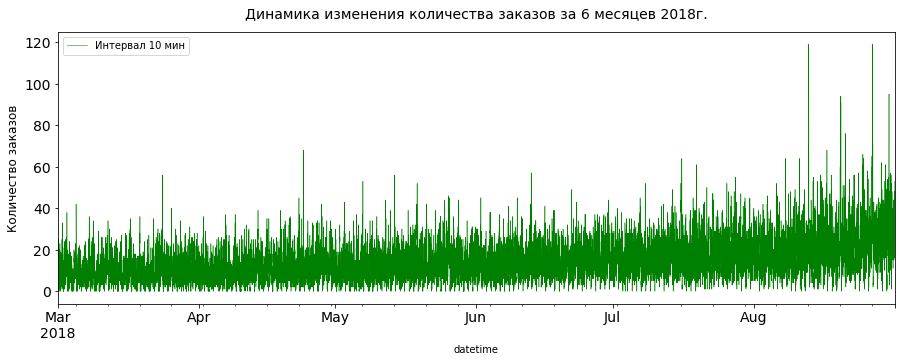

In [10]:
plt.figure(figsize=(15,5))
_= data.plot(linewidth = 0.5, color = "green",ax=plt.gca())

plt.legend(["Интервал 10 мин"])
plt.title("Динамика изменения количества заказов за 6 месяцев 2018г.", size=14, y=1.03)
plt.ylabel("Количество заказов", size=12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Можно предположить, что среднее количество заказов в августе выросло. Также выросли скачки нагрузки, иногда могли достигать 120 заказов! Популярность такси в аэропорту набирала обороты. Все поехали в отпуска, увеличилось количество рейсов

Построим стационарный ряд в этом же временном периоде.

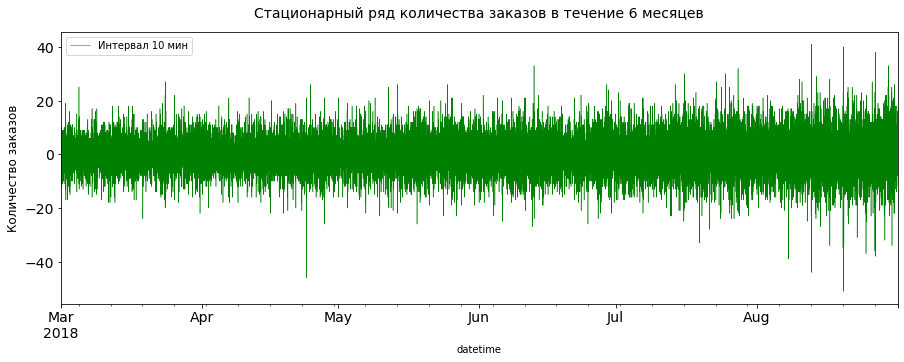

In [11]:
plt.figure(figsize=(15,5))
data_stationary = data.copy()

# строим график разностей в количестве заказов
data_stationary.diff().plot(linewidth = 0.5,
                 color = "green",
                 ax=plt.gca()
                )

plt.legend(["Интервал 10 мин"])
plt.title("Стационарный ряд количества заказов в течение 6 месяцев", size=14, y=1.03)
plt.ylabel("Количество заказов", size=12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Теперь можно увидеть, что большая часть дифференциалов с высоким отклонением также характерна для августа.Есть большой скачок в конце апреля, который можно обьяснить возвращением путешественников с 'зимовки' в теплых странах.

Проверим данные на наличие аномалий.

In [12]:
def find_outliers(df, percent, print_plot=False, remove_outliers=False):
    
    # копирование dataset
    df_outliers = df.copy()
#    df_outliers.drop(['datetime'], axis=1, inplace=True)
    
    # Поиск выбросов с помощью IsolationForest
    isf = IsolationForest(contamination = percent)
    y_pred = isf.fit_predict(df_outliers)
    df_outliers['is_outlier'] = y_pred
    
    # изображение гистограммы
    if print_plot:
        
        fig, ax = plt.subplots(1,1, figsize=(18,5))
        ax.set_xlabel('Period', fontsize = 16)
        ax.set_ylabel('Net Sales', fontsize = 16)
        ax.set_title('Outliers', fontsize = 16)
        ax.scatter(df_outliers.index
                   , df_outliers['num_orders']
                   , c = df_outliers['is_outlier']);
    
    if remove_outliers:
        
        # применение результата к исходному набору данных
        df_outliers.drop(['num_orders'], axis=1, inplace=True)
        df_outliers = pd.concat([df, df_outliers], axis=1)

        # удаление выбросов
        df_outliers.loc[(df_outliers['is_outlier'] == -1), 'num_orders'] = np.nan
    
    return df_outliers.dropna()

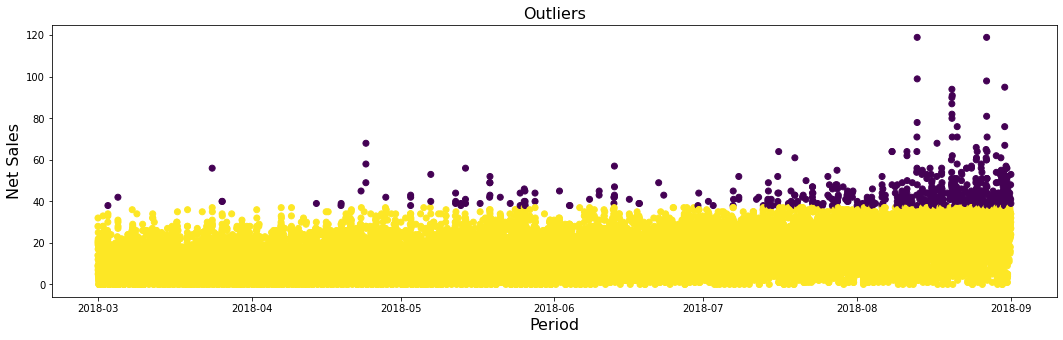

In [13]:
data_neat = find_outliers(data, 0.02, print_plot=True, remove_outliers=True)

189 знaчений  -  аномальные. Без них будущая модель сможет качественнее обучиться. Но эти данные могут помочь в достижении главной цели - предсказание пиковых показателей. Ведь основная их часть лежит в августе - самом пиковом месяце данных. Не будем  пока удалять их!

In [14]:
# функция для отслеживания изменений во временном ряде

def plot_ts(df_time, title, rolling_window):
    ''' Cтроит графики временного ряда,
    скользящего отклонения и скользящего среднего
    
    Принимает на вход датафрейм
    вывод три графика в одном
    '''
    
    plt.figure(figsize=(10,5));

    (df_time
         # считаем скользящее среднее и стандартное отклонение 
         # для временного ряда
         .assign(
              rolling_mean = lambda x: x.num_orders.rolling(rolling_window, closed='left').mean(),
              rolling_std = lambda x: x.num_orders.rolling(rolling_window, closed='left').std()
         ) 
         .plot(ax=plt.gca())
    );

    plt.legend(['Временной ряд', "Скользящее среднее", "Скользящее отклонение"], fontsize=12)
    plt.ylabel("Количество заказов", size=12)
    plt.xlabel("Дата/время", size=12)
    plt.title(title, size=14, y=1.03)
    plt.tick_params(axis='both', which='major', labelsize=14,)
    plt.show()
   


Рассмотри визуальный ряд в разрезе часов и дней.

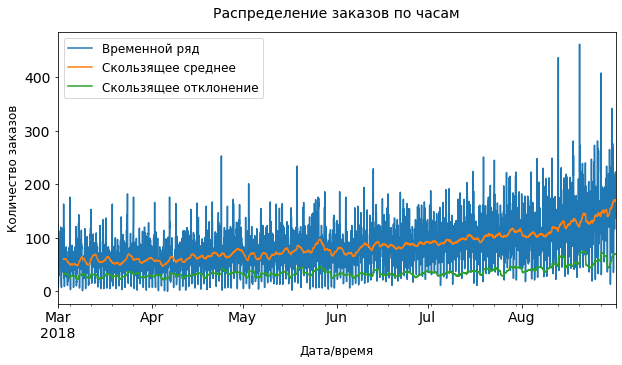

In [15]:
plot_ts(data_hour, 'Распределение заказов по часам', 48)

In [16]:
data_day = data_hour.resample('1D').sum()

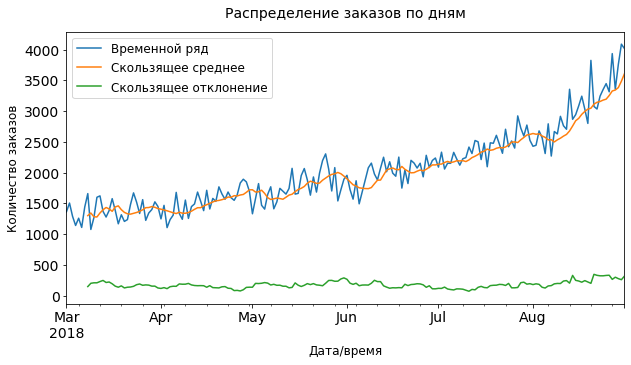

In [17]:
plot_ts(data_day, 'Распределение заказов по дням', 7)

Визуально очевидно, что ряд не стационарен.

Так же можно увидеть четкий тренд, как растет спрос на такси.

Количество заказов в час увеличилось с 1300 до 3000 заказов всего за полгода!

Самый быстрый рост наблюдается в мае и августе. Рассмотри август точнее.

Разложим данные на три составляющие: тренд, сезонность и остаток. 

Построим графики последнего месяца временного ряда и проанализируем данные.

In [18]:
df_august = data_hour['2018-08':'2018-08']

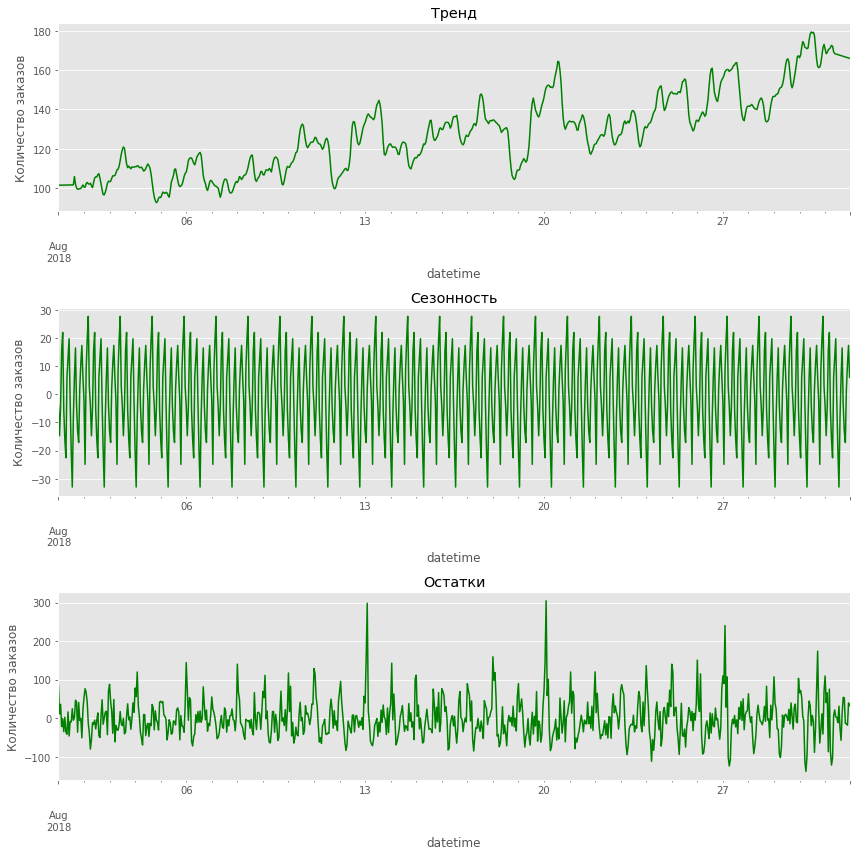

In [19]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(df_august, model='additive', extrapolate_trend='freq', period=30)
plt.figure(figsize=(12, 12))

plt.subplot(311)
plt.ylabel("Количество заказов", size=12)
decomposed.trend.plot(color = "green",ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(color = "green",ax=plt.gca())
plt.ylabel("Количество заказов", size=12)
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(color = "green",ax=plt.gca())
plt.ylabel("Количество заказов", size=12)
plt.title('Остатки')
plt.tight_layout()

Распределение сезонной части выглядит статическим в интервале суток. Ночью такси чаще заказывают, ведь днем есть общественный транспорт(метро/аэроэкспресс), которым можно добратьтся до аэропорта.

Остатки(случайная часть) также имеет постоянной среднее значение, но периодически возникают провалы.
Трэнд показывает линейный рост количества заказов со временем. 


Построим тренд для всего временного ряда, чтобы увидеть полную картину.

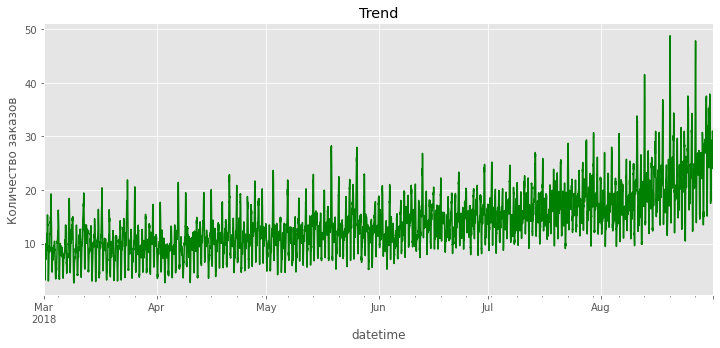

In [20]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(data, model='additive', extrapolate_trend='freq', period=30)
plt.figure(figsize=(12, 5))
plt.ylabel("Количество заказов", size=12)
decomposed.trend.plot(color = "green", ax=plt.gca())
plt.title('Trend');

Трэнд имеет более сложную зависимость от времени (квадраичная или экспоненциальная, сложно оценить по днной выборке). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).
Также заметим, что линия тренда имеет некоторый шум. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов.

**Исследование стационарности**

Выдвигаем гипотезу, что наш временной ряд нестационарный - Н0.
Обратная гипотеза: Н1 - временной ряд стационарный.

Тест **Дики-Фуллера(Dickey-Fuller)**

In [21]:
# adf, pval, usedlag, nobs, crit_vals, icbest = adfuller(data.num_orders)
# print(adf, pval, usedlag, nobs, crit_vals, icbest)
print(" Статистический тест Дики-Фуллера")
print("Н0: временной ряд нестационарный\n")
print("Н1: временной ряд стационарный\n")
# запускаем тест Дики-Фуллера

test_results = adfuller(data_hour.num_orders)

print(f"ADfuller-критерий: {test_results[0]: .2f}")
print(f"p-value: {test_results[1]: .3f}")
print('Критические значения:')
# перебираем масс
for perc, value in test_results[4].items():
    print(f"{perc}: {value: .2f}")

# если значение попадает в интервал с вероятностью < 5%
# отвергаем нулевую гипотезу
if test_results[0] < test_results[4]["5%"]:
    
    print ("Отвергаем нулевую гипотезу")
else:
    print("Нулевая гипотеза не может быть отвергнута") 

 Статистический тест Дики-Фуллера
Н0: временной ряд нестационарный

Н1: временной ряд стационарный

ADfuller-критерий: -3.07
p-value:  0.029
Критические значения:
1%: -3.43
5%: -2.86
10%: -2.57
Отвергаем нулевую гипотезу


Значение p-value < 5% (критерий ADF < критиеческого значения 5%), значит, мы отвергаем нулевую гипотезу. На уровне 0.05 ряд нестационарен.

С учетом стационарности графика данных,построенного выше, проверим тестом Дики-Фулера данные на уровне 1%.

In [22]:
print(" Статистический тест Дики-Фуллера")
print("Н0: временной ряд нестационарный\n")
print("Н1: временной ряд стационарный\n")
# запускаем тест Дики-Фуллера

test_results = adfuller(data_hour.num_orders)

print(f"ADfuller-критерий: {test_results[0]: .2f}")
print(f"p-value: {test_results[1]: .3f}")
print('Критические значения:')
# перебираем масс
for perc, value in test_results[4].items():
    print(f"{perc}: {value: .2f}")

# если значение попадает в интервал с вероятностью < 5%
# отвергаем нулевую гипотезу
if test_results[0] < test_results[4]["1%"]:
    
    print ("Отвергаем нулевую гипотезу")
else:
    print("Нулевая гипотеза не может быть отвергнута") 

 Статистический тест Дики-Фуллера
Н0: временной ряд нестационарный

Н1: временной ряд стационарный

ADfuller-критерий: -3.07
p-value:  0.029
Критические значения:
1%: -3.43
5%: -2.86
10%: -2.57
Нулевая гипотеза не может быть отвергнута


**Вывод**

Наша гипотеза о наличии тренда и нестационарности данных подтвердилась более детальным(0,01) тестом Дики-Фулера

В следующем блоке мы проведем разностное преобразование для удаления линейного тренда из серии.

**Дифференцирование**

Построим график разностей между количеством заказов с помощью diff().

И добавим новые параметры - mean и std. Нужно убедиться, что в преобразованных данных они не меняются со временем.

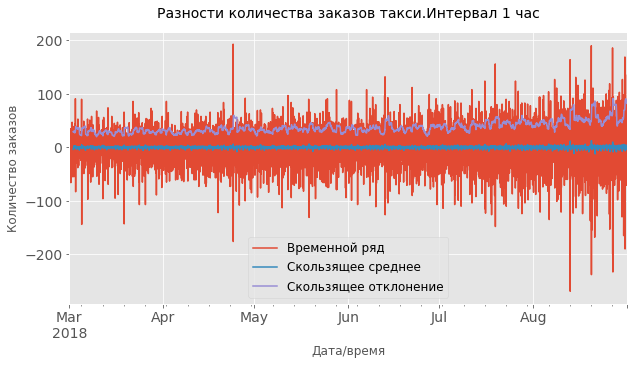

In [22]:
data_time = data_hour.diff()
# Строим график временного ряда после дифферецирования
plot_ts(data_time, 'Разности количества заказов такси.Интервал 1 час', 30)

Дифференцирование удалило растущий тренд в данных (среднее случайной величины временного ряда)

Стал ли теперь ряд полностью стационарным? К сожалению, нет, т.к. вариативность по-прежнему меняется со временем.

**Автокорреляция ACF**

Для поиска зависимостей временного ряда от данных в прошлом воспользуемся функцией автокорреляции ACF

График, построенный с помощью **plot_acf**, позволит увидеть:

- есть ли корреляция с различными лагами временного ряда

- есть ли тренды/сезонность во временном ряде

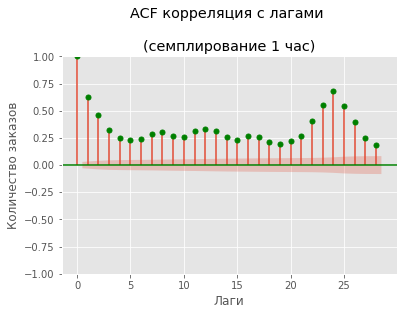

In [23]:
plot_acf(data_hour['num_orders'], title="ACF корреляция с лагами \n\n(семплирование 1 час)",color = "green", lags = 28)
plt.xlabel("Лаги", size=12)
plt.ylabel("Количество заказов", size=12)
plt.show()

График показывает высокую корреляцию заказов в текущий час с количеством заказов в предыдыдущие 24 часа (прошлый день)

Тот самый тренд с ежедневным ростом среднего количества заказов:)

Возьмем большее количество лагов = 80

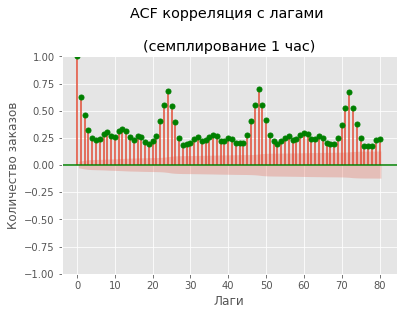

In [24]:
plot_acf(data_hour['num_orders'], title="ACF корреляция с лагами \n\n(семплирование 1 час)",color = "green", lags=80)
plt.xlabel("Лаги", size=12)
plt.ylabel("Количество заказов", size=12)
plt.show()

Получается, изначальный график показал нам именно период изменений. Теперь мы можем увидеть, как этот тренд циклично повторяется и показывает нам сезонность относительно дней.

Как выглядел график исходных данных до семплирования по 1 часу?

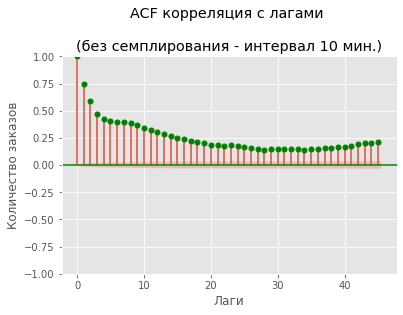

In [25]:
plot_acf(data['num_orders'], title="ACF корреляция с лагами \n\n(без семплирования - интервал 10 мин.)", color = "green")
plt.xlabel("Лаги", size=12)
plt.ylabel("Количество заказов", size=12)
plt.show()

Такой плавный спад значений автокорреляции означает, что исходный ряд был `нестационарным

Получается, именно семплирование дало нам возможность отследить тренды и сезонность в датасете. Т.к. здесь мы не наблюдаем таких же "цикличных" повышений корреляции.

Как будет выглядеть график, если мы построим его теперь для дифференцированных данных (после семплирования)?

/opt/conda/lib/python3.9/site-packages/matplotlib/axes/_base.py:2141: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


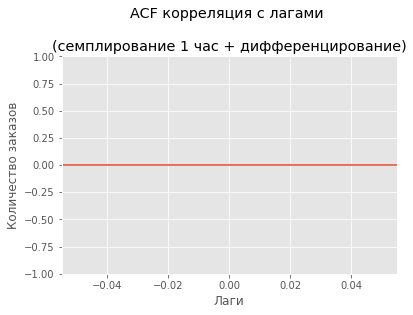

In [26]:
plot_acf(data_hour['num_orders'].diff(), title="ACF корреляция с лагами \n\n(семплирование 1 час + дифференцирование)")
plt.xlabel("Лаги", size=12)
plt.ylabel("Количество заказов", size=12)
plt.show()

Прямая...как же теперь делать предсказания? Вспомним, как выглядел график с дифференцированными данными(он в пункте выше).После удаления тренда из данных, остались только колебания вдоль прямой (видимо поэтому у нас прямая линия без корреляций с прошлым).

Есть данные, которые выходят за границы отрезка [-100, 100]. Посмотрим, как они меняют общую картину.

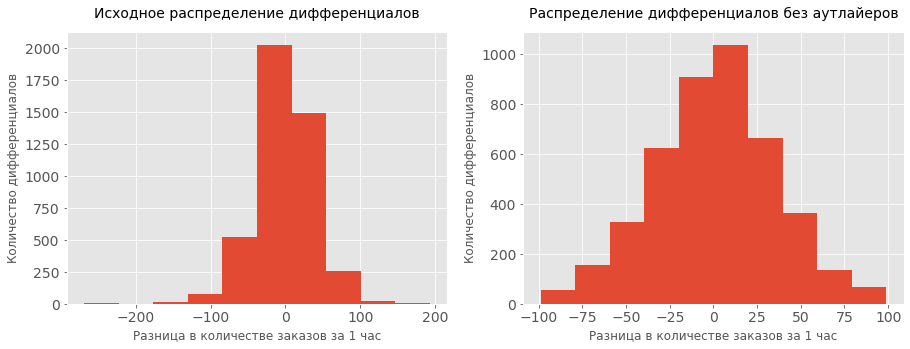

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5));

ax1 = data_hour['num_orders'].diff().hist(ax=axes[0])
ax2 = data_hour['num_orders'].diff()[data_hour['num_orders'].diff().abs() < 100].hist(ax=axes[1])

for ax in [ax1,ax2]:    
    ax.set_xlabel("Разница в количестве заказов за 1 час", size=12)
    ax.set_ylabel("Количество дифференциалов", size=12)
    ax.tick_params(axis='both', which='major', labelsize=14)

ax1.set_title("Исходное распределение дифференциалов", size=14, y=1.03)
ax2.set_title("Распределение дифференциалов без аутлайеров", size=14, y=1.03)

plt.show()

**Вывод**

- Мы увидели, как именно семплирование влияет на исходные данные, делает их дискретными и позволяет увидеть тренды.

- Провели оценку стационарности с помощью Дики-Фуллера и автокорреляции ACF

- Убедились в том, что дифференцирование позволяет избавиться от циклических трендов во времени и сделать сделать ряд ряд более стационарным

- Оценили влияние аномалий на данные.

В текущем проекте для supervised learning обучения будем использовать недеффиренцированные данные, создавая отдельные признаки для предсказаний.

## Обучение

В качестве baseline модели будем предсказывать **новые значения предыдущими.**

In [28]:
#Разделим данные на выборки
train_first, test_first = train_test_split(data_hour, shuffle=False, test_size=0.1)

In [29]:
print("Выборки для обучения модели и тестирования. \n")
print(f"Итоговая обучающая выборка")
print(f" размер: {train_first.shape[0]} | {train_first.index.date.min()} - {train_first.index.date.max()}")
print(f"Тестовая выборка")
print(f" размер: {test_first.shape[0]}  | {test_first.index.date.min()} - {test_first.index.date.max()}")

Выборки для обучения модели и тестирования. 

Итоговая обучающая выборка
 размер: 3974 | 2018-03-01 - 2018-08-13
Тестовая выборка
 размер: 442  | 2018-08-13 - 2018-08-31


Итоговый тест у нас пройдет на данных во второй половине августа (когда мы наблюдали сильные изменения в спросе на такси)

Подбор признаков будем валидировать на данных о заказах такси до первой половины августа

In [30]:
train_first = train_first.dropna()
pred_previous = test_first.shift()
pred_previous.iloc[0] = train_first.iloc[-1]
rmse_base =  mean_squared_error(test_first['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", round(rmse_base, 3))

RMSE baseline модели: 58.856


Проверим предсказания **по среднему значению.**

In [31]:
pred_mean = np.ones(test_first.shape) * train_first['num_orders'].mean()
print("RMSE baseline модели:", mean_squared_error(test_first['num_orders'], pred_mean) ** 0.5)

RMSE baseline модели: 84.74414402014742


Предсказания по предыдущему значению показывают лучший результат. Возьмём их в качестве baseline.

**Автокорреляция PACF - поиск закономерностей**

Характеристики временного ряда - это количество лагов и окно для скользящего среднего. В идеале, они определяются по графикам ACF / PCF.

В отличии от автокорреляции, PACF показывает не корреляцию временного ряда с самим собой, а текущего наблюдения в данных и его лагом во времени.

Таким образом, PCAF не учитывает тренды и сезонность, а находит корреляции, которые может найти в Residuals временного ряда.

Отсюда и название Partial Autocorrelation Function - частичная автокорреляция.

Поэтому график PACF может помочь нам найти полезные лаг-features для моделирования!

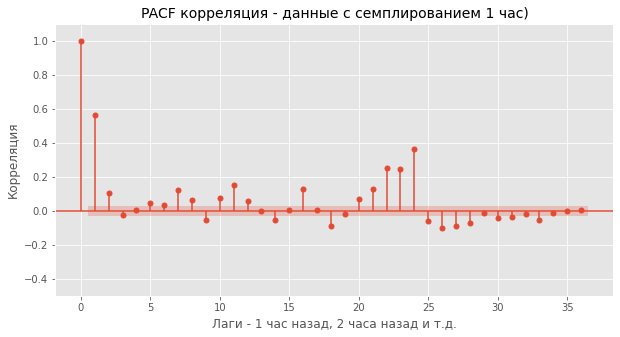

In [32]:
plt.figure(figsize=(10, 5))

plot_pacf(train_first.num_orders, ax=plt.gca(), method='ywm');

plt.title("PACF корреляция - данные с семплированием 1 час)", size = 14)
plt.xlabel("Лаги - 1 час назад, 2 часа назад и т.д.", size=12)
plt.ylabel("Корреляция", size=12)
plt.ylim([-0.5, 1.1])
plt.grid(True)
plt.show()

- 0-й лаг - это текущее количество заказов, поэтому здесь корреляция = 1

- Достаточно много значений вошли в 95%-й доверительный интервал, но мы возьмем только самые выдающиеся:)

- Попробуем взять больший период для лагов

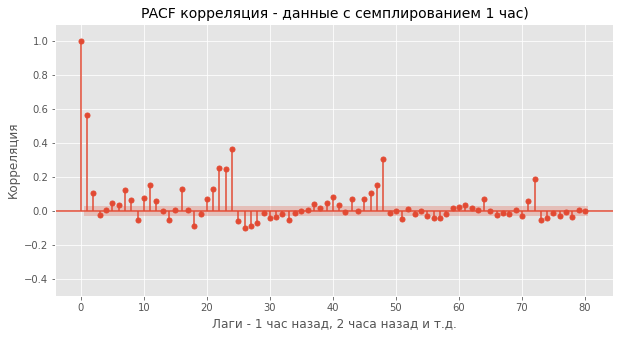

In [33]:
plt.figure(figsize=(10, 5))

plot_pacf(train_first.num_orders, ax=plt.gca(), method='ywm', lags=80);

plt.title("PACF корреляция - данные с семплированием 1 час)", size = 14)
plt.xlabel("Лаги - 1 час назад, 2 часа назад и т.д.", size=12)
plt.ylabel("Корреляция", size=12)
plt.ylim([-0.5, 1.1])
plt.grid(True)
plt.show()

Корреляция постепенно затухает. Дальше одного дня заглядывать не будем, оставим эти данные для rolling-признаков

Вывод:

PCAF показал нам самую сильную корреляцию с лагами:
- 1 час
-  22 часа, 23 часа и 24 часа
Это логично, на спрос сильно влияет количество заказов в предыдущий день и час назад.

На втором месте корреляции с лагами - 2, 7, 11, 16, 21 и  18 часов. Почти постоянен интервал 5 часов.

Следующим шагом выделим топ лагов и построим матрицу корреляций с ними.

In [34]:
features_list =['lag_1', 'lag_2', 'lag_7', 
                'lag_11','lag_16', 'lag_18', 
                'lag_21','lag_22', 'lag_23',
                'lag_24']
best_lags = [1, 2, 7, 11, 16, 18, 21, 22, 23, 24]


Напишем функцию для создания обучающих признаков.

In [35]:
def make_features_best(data, lags_list, rolling_mean_size):
    ''' Функция  создает признаки day, dayofweek,
    скользящего среднего rolling_mean (с размером окна rolling_mean_size)
     и lag_i для признаков отстающего значения.'''
    make_data = data.copy()
    
    data['day'] = make_data.index.day
    data['dayofweek'] = make_data.index.dayofweek
    
    for lag in lags_list:
        make_data['lag_{}'.format(lag)] = make_data['num_orders'].shift(lag)
    make_data['rolling_mean'] = make_data['num_orders'].shift().rolling(rolling_mean_size).mean() 

    return make_data.dropna()

def make_features(data, max_lag, rolling_mean_size):
    ''' Функция  создает признаки day, dayofweek,
    скользящего среднего rolling_mean (с размером окна rolling_mean_size)
     и lag_i для признаков отстающего значения.'''
    
    make_data = data.copy()
    
    make_data['day'] = make_data.index.day
    make_data['dayofweek'] = make_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        make_data['lag_{}'.format(lag)] = make_data['num_orders'].shift(lag)
    make_data['rolling_mean'] = make_data['num_orders'].shift().rolling(rolling_mean_size).mean() 

    return make_data.dropna()

In [72]:
df = make_features(data_hour, 50, 3)
display(df.head())

df_best_lags = make_features_best(data_hour, best_lags, 3)
display(df_best_lags.head())

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,3,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,114.333333
2018-03-03 03:00:00,64,3,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,98.666667
2018-03-03 04:00:00,44,3,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,65.666667
2018-03-03 05:00:00,15,3,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,44.333333
2018-03-03 06:00:00,9,3,5,15.0,44.0,64.0,25.0,108.0,163.0,72.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,41.000000


,num_orders,day,dayofweek,lag_1,lag_2,lag_7,lag_11,lag_16,lag_18,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,58.0,113.0,44.0,32.0,34.0,12.0,66.0,71.0,85.0,124.0,79.000000
2018-03-02 01:00:00,120,2,4,90.0,58.0,73.0,48.0,69.0,15.0,43.0,66.0,71.0,85.0,87.000000
2018-03-02 02:00:00,75,2,4,120.0,90.0,45.0,66.0,64.0,34.0,6.0,43.0,66.0,71.0,89.333333
2018-03-02 03:00:00,64,2,4,75.0,120.0,61.0,43.0,96.0,69.0,12.0,6.0,43.0,66.0,95.000000
2018-03-02 04:00:00,20,2,4,64.0,75.0,66.0,44.0,30.0,64.0,15.0,12.0,6.0,43.0,86.333333


In [73]:
#Разделим данные в соотношении 9:1 (10% тестовой выборки).
train_df, test_df = train_test_split(df, shuffle=False, test_size=0.1)


features_train = train_df.drop('num_orders', axis=1)
features_test = test_df.drop('num_orders', axis=1)
target_train = train_df['num_orders']
target_test = test_df['num_orders']

In [74]:
#Разделим данные в соотношении 9:1 (10% тестовой выборки).
train_bl, test_bl = train_test_split(df_best_lags, shuffle=False, test_size=0.1)

features_train_bl = train_bl.drop('num_orders', axis=1)
features_test_bl = test_bl.drop('num_orders', axis=1)
target_train_bl = train_bl['num_orders']
target_test_bl = test_bl['num_orders']

**Линейная регрессия**

Выделим категоральные признаки для OneHotEncoder

In [75]:
features_train_one = features_train.copy()
features_train_bl_one = features_train_bl.copy()

#дискретные признаки day и dayofweek
ohe_features = features_train_one.select_dtypes(include='int').columns.to_list()
ohe_features_bl = features_train_bl_one.select_dtypes(include='int').columns.to_list()
print(ohe_features_bl)

#численные непрерывные признаки
num_features = features_train_one.select_dtypes(exclude='int').columns.to_list()
num_features_bl = features_train_bl_one.select_dtypes(exclude='int').columns.to_list()
print(num_features_bl)

['day', 'dayofweek']
['lag_1', 'lag_2', 'lag_7', 'lag_11', 'lag_16', 'lag_18', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean']


Обучим модель

In [65]:
def evaluate(model, X, y, cv):
    
    '''Функция оценки модели прогнозирования временного ряда
    принимает на вход model, признаки(X, y), кросс-валидацию
    выдает усредненную метрику качества модели'''
    
    cv_results = cross_validate(model, X, y, cv=cv,
                                scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"]
                               )
    
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(f"RMSE  выборки: {rmse.mean():.3f}")


Для начала обучим линейную регрессию на данных с сохраненной последовательностью лагов, далее с лучшими лагами. 

In [89]:
#кодирование признаков: day и dayofweek- кодируются, остальные - масштабируются.
# установим handle_unknown='ignore' чтобы новые, 
#ранее неизвестные значения игнорировались и не включались в итоговую матрицу, 
#drop='first' для избежания деми ловушки
col_transformer_lr= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error', sparse=False),
        features_train_one.select_dtypes(include='int').columns.to_list()
    ),
    (
        StandardScaler(),
        features_train_one.select_dtypes(exclude='int').columns.to_list()
    ),
    remainder='passthrough
)

#присвоение модели
model_lr = LinearRegression()

#кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=3)

pipline_lr = make_pipeline(col_transformer_lr,  model_lr)


pipline_lr.fit(features_train_one, target_train)

#общее RMSE обучающей выборки
evaluate(pipline_lr, features_train_one, target_train, cv=tscv)

RMSE на кросс-валидации выборки: 27.689


Линейная регрессия показала отличныее результаты!

Рассмотри ее работу на признаках с отобранными  Лагами.

In [92]:
col_transformer_lr= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error', sparse=False),
        features_train_bl_one.select_dtypes(include='int').columns.to_list()
    ),
    (
        StandardScaler(),
        features_train_bl_one.select_dtypes(exclude='int').columns.to_list()
    ),
    remainder='passthrough'
)

#присвоение модели
model_lr_bl = LinearRegression()

#кросс-валидация для временных рядов
tscv = TimeSeriesSplit(n_splits=3)

pipline_lr_bl = make_pipeline(col_transformer_lr, model_lr_bl)

pipline_lr_bl.fit(features_train_bl_one, target_train_bl)

#общее RMSE обучающей выборки
evaluate(pipline_lr_bl, features_train_bl_one, target_train_bl, cv=tscv)

RMSE на кросс-валидации выборки: 28.332


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> `OneHotEncoder` полезно настраивать на бесперебойную работу при появлении в новых данных ранее неизвестных значений признаков: по умолчанию в таких случаях `OneHotEncoder` будет выбрасывать ошибку, однако для непрерывности процесса моделирования можно настроить параметр `handle_unknown='ignore'`, чтобы новые, ранее неизвестные значения игнорировались и не включались в итоговую матрицу.
        
То же касается `OrdinalEncoder`: по умолчанию в таких случаях `OrdinalEncoder` будет выбрасывать ошибку, однако для непрерывности процесса моделирования можно настроить параметры `handle_unknown='use_encoded_value'`, чтобы новые, ранее неизвестные значения кодировались константным значением, а в параметр `unknown_value` нужно передать само значение-константу. 

Данные изменились совсем немниго.
Применение в модели выборки с лучшими лагами увеличило ошибку на тестовой выборке. Возможно модель стала менее чувствительна к переобучению благодаря этому. Возможно причина все-таки в корреляциях, которые мы успели заметить в данных?  Будем учитывать это в дальнейших подсчетах.

В итоге, с помощью одних только лагов-признаков можно получить неплохие предсказания.Для подбора лагов, которые коррелируют с целевым признаком, эффективно использовать графики PACF. Лучший набор признаков сохранен в best_lags. 

Вероятнее всего, сложные модели будут сильно переобучаться. Модель Линейной Регрессии отлично показала себя на тренировойных данных.

Проверим это предположение на других моделях.

**RidgeRegression**

Подбирём гиперпараметры с помощью GridSearchCV, используя  кросс-валидацию для временных рядов в TimeSeriesSplit, для модели Ridge.

In [103]:
#кодирование признаков: day и dayofweek- кодируются, остальные - масштабируются.
col_transformer_ridge= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error', sparse=False),
        features_train_bl_one.select_dtypes(include='int').columns.to_list()
    ),
    (
        StandardScaler(),
        features_train_bl_one.select_dtypes(exclude='int').columns.to_list()
    ),
    remainder='passthrough'
)


# random_state не перебирается, задаём его прямо в модели
model_ridge = Ridge(random_state=state)

pipline_ridge_bl = make_pipeline(col_transformer_ridge, model_ridge)

tscv = TimeSeriesSplit(n_splits=3)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {'ridge__alpha': np.arange(0, 22, 2)}

gs_ridge = GridSearchCV(pipline_ridge_bl,
                        param_grid=param_grid_ridge,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1, 
                        cv=tscv.split(train_bl)
                       )

gs_ridge.fit(features_train_bl_one,target_train_bl)

# лучшее значение RMSE на кросс-валидации
print(f'RMSE на тестовой выборке с лучшими лагами: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'Лучшие гиперпараметры:  {gs_ridge.best_params_}')

RMSE на тестовой выборке с лучшими лагами: 27.52077162418662
Лучшие гиперпараметры:  {'ridge__alpha': 20}


**Случайный лес**

In [104]:
#кодирование признаков
col_transformer_rf= make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
        features_train_bl_one.select_dtypes(include='int').columns.to_list()
    ),
    (
        StandardScaler(),
        features_train_bl_one.select_dtypes(exclude='int').columns.to_list()
    ),
    remainder='passthrough'
)

In [105]:
model_rf = RandomForestRegressor(random_state=state)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)


In [106]:
param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}

tscv = TimeSeriesSplit(n_splits=3)

# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=tscv.split(train_bl)
)

gs_rf.fit(features_train_bl_one,target_train_bl)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
print(f'RMSE на тестовой выборке с лучшими лагами: {gs_rf_best_score}')
print(f'Лучшие гиперпараметры: {gs_rf_best_params}')

RMSE на тестовой выборке с лучшими лагами: 27.8085988989525
Лучшие гиперпараметры: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 11}


**LGBMRegressor**

In [107]:
# сменим тип категориальных признаков ohe_features_bl из features_train_bl

cat_features_train_bl = features_train_bl.copy()
cat_features_train_bl[ohe_features_bl] = cat_features_train_bl[ohe_features_bl].astype('category')
print(cat_features_train_bl.info())

cat_features_test_bl = features_test_bl.copy()
cat_features_test_bl[ohe_features_bl] = cat_features_test_bl[ohe_features_bl].astype('category')

# объеденим закодированный features и target для TimeSeriesSplit
cat_train_bl = pd.concat([cat_features_train_bl,target_train_bl], axis= 1)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3952 entries, 2018-03-02 00:00:00 to 2018-08-13 15:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   day           3952 non-null   category
 1   dayofweek     3952 non-null   category
 2   lag_1         3952 non-null   float64 
 3   lag_2         3952 non-null   float64 
 4   lag_7         3952 non-null   float64 
 5   lag_11        3952 non-null   float64 
 6   lag_16        3952 non-null   float64 
 7   lag_18        3952 non-null   float64 
 8   lag_21        3952 non-null   float64 
 9   lag_22        3952 non-null   float64 
 10  lag_23        3952 non-null   float64 
 11  lag_24        3952 non-null   float64 
 12  rolling_mean  3952 non-null   float64 
dtypes: category(2), float64(11)
memory usage: 508.9 KB
None


In [108]:
model_lgbmr = LGBMRegressor(random_state=state) 

param_grid_lgbmr = {'max_depth': range(2, 15),
                   'n_estimators': range(50, 250, 50)}


In [109]:
tscv = TimeSeriesSplit(n_splits=3)

# будем использовать RandomizedSearchCV
gs_lgbmr = RandomizedSearchCV(model_lgbmr,
                              param_distributions=param_grid_lgbmr,
                              scoring='neg_mean_squared_error',
                              cv=tscv.split(cat_train_bl)
                             )

In [110]:
gs_lgbmr.fit(cat_features_train_bl, target_train_bl)

best_params_LGBMR = gs_lgbmr.best_params_
gs_lgbmr_best_score = (gs_lgbmr.best_score_ * -1)** 0.5
print(f'RMSE на тестовой выборке с лучшими лагами: {gs_lgbmr_best_score}')
print(f'Лучшие гиперпараметры: {best_params_LGBMR}')

RMSE на тестовой выборке с лучшими лагами: 28.465393584067453
Лучшие гиперпараметры: {'n_estimators': 50, 'max_depth': 6}


**CatBoostRegressor** без кодирования

In [111]:
model_cbr = CatBoostRegressor(random_state=state, cat_features=['day','dayofweek']) 

param_grid_cbr = {'learning_rate': [0.1, 0.4],
                  'depth': [2, 4, 6, 10],
                  'n_estimators': [100,150, 10],
                  'l2_leaf_reg': [1, 3, 5, 7, 9]}

tscv = TimeSeriesSplit(n_splits=3)

# будем использовать RandomizedSearchCV
gs_cbr = RandomizedSearchCV(model_cbr,
                            param_distributions=param_grid_cbr,
                            scoring='neg_mean_squared_error',
                            cv=tscv.split(cat_train_bl)
                           )

gs_cbr.fit(cat_features_train_bl, target_train_bl)

best_params_cbr = gs_cbr.best_params_
gs_cbr_best_score = (gs_cbr.best_score_ * -1)** 0.5
print(f'RMSE на тестовой выборке с лучшими лагами: {gs_cbr_best_score}')
print(f'Лучшие гиперпараметры: {best_params_cbr}')

0:	learn: 24.1272278	total: 49.9ms	remaining: 7.44s
1:	learn: 21.5772011	total: 52.2ms	remaining: 3.86s
2:	learn: 19.8657836	total: 54.4ms	remaining: 2.66s
3:	learn: 18.5144580	total: 56.6ms	remaining: 2.06s
4:	learn: 17.6966180	total: 58.6ms	remaining: 1.7s
5:	learn: 17.3889229	total: 60.5ms	remaining: 1.45s
6:	learn: 17.0271180	total: 62.7ms	remaining: 1.28s
7:	learn: 16.7049117	total: 64.9ms	remaining: 1.15s
8:	learn: 16.6217963	total: 66.9ms	remaining: 1.05s
9:	learn: 16.4031740	total: 69ms	remaining: 966ms
10:	learn: 16.1054479	total: 71ms	remaining: 898ms
11:	learn: 15.9760952	total: 72.9ms	remaining: 838ms
12:	learn: 15.7480607	total: 74.9ms	remaining: 790ms
13:	learn: 15.4540645	total: 76.8ms	remaining: 746ms
14:	learn: 15.3154707	total: 78.8ms	remaining: 709ms
15:	learn: 15.2898390	total: 79.5ms	remaining: 665ms
16:	learn: 15.0547471	total: 81.6ms	remaining: 639ms
17:	learn: 14.9673152	total: 83.6ms	remaining: 613ms
18:	learn: 14.6544350	total: 85.5ms	remaining: 589ms
19:	lear

**ARIMA**

Прибегнем к более сложной модели прогнозирования векторных данных ARIMA.
Для этой модели воспользуемся процессом автоматического определения наиболее оптимальных параметров модели ARIMA. Этот процесс основан на широко используемой функции R forecast::auto.arima.

Период сезонной разницы m в ней относится к количеству периодов в каждом сезоне, установим  m = 1, как для годовых (несезонных) данных.

Auto-ARIMA работает путем проведения тестов на различение (т. е. Квятковского-Филлипса-Шмидта-Шина, расширенного Дикки-Фуллера или Филлипса-Перрона) для определения порядка дифференцирования , а затем подгонки dмоделей в пределах определенных start_p, max_p, start_q, max_qдиапазонов.

In [ ]:
df_arima = data_hour.drop(['day','dayofweek'], axis=1)

In [ ]:
#Разделим данные в соотношении 9:1 (10% тестовой выборки).
train_neat, test_neat = train_test_split(df_arima, shuffle=False, test_size=0.1)


train_neat = train_neat
features_train_neat = train_neat.drop('num_orders', axis=1)
target_train_neat = train_neat['num_orders']
target_test_neat = test_neat['num_orders']

In [ ]:
auto_arima(df_arima, seasonal=True, m=1).summary()

In [ ]:
TEST_SIZE = int(0.1 * data.shape[0])

train = data.iloc[:-TEST_SIZE]
test = data.iloc[-TEST_SIZE:]

model_arima = SARIMAX(target_train_neat,order=(0, 1, 2))
results=model_arima.fit()
results.summary()

In [ ]:
xstart=len(train_neat)
xend=len(train_neat)+len(test_neat)-1

predictions=results.predict(start=xstart, end=xend, dynamic=False, typ='levels').rename('SARIMAX Results')

In [ ]:
predictions_train = results.predict(start=0, end=xstart-1, dynamic=False, typ='levels').rename('SARIMAX Results')

rmse_error_train = rmse(target_train_neat, predictions_train)

rmse_error_train

In [ ]:
rmse_error_test = rmse(target_test_neat, predictions)
rmse_error_test

Результат на тестовый выборке выше, чем у других моделей. Скорость расчетов и их лаконичность впечетляют.

**Вывод**

Были изучены 6 моделей машинного обучения на данных разной кодировки.

Найдены лучшие гиперпараметры для моделей, оценили метрики качества моделей RMSE.

- baseline предсказания новых значений предыдущими
RMSE = 58,8;

- baseline предсказания новых значений средниму значению
RMSE = 84,7;

- LinearRegression
RMSE = 27.67, 

- RidgeRegression
RMSE = 27,53, 'alpha': 18;

- RandomForestRegressor
RMSE = 27.856001775947636, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 12;

- LGBMRegressor
RMSE : 28.47, 'n_estimators': 50, 'max_depth': 6 

- CatBoostRegressor
RMSE : 27.468, 'n_estimators': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'depth': 4;

- ARIMA
RMSE : 31.69.

Модели регрессии показали себя очень хорошо! Но лучше всех с задачей справилась модель CatBoostRegressor .

## Тестирование

In [112]:
model_cbr = CatBoostRegressor(n_estimators=100, 
                              learning_rate=0.1, 
                              l2_leaf_reg=1, 
                              depth=4, 
                              random_state=state, 
                              cat_features=['day','dayofweek'])
model_cbr.fit(cat_features_train_bl, target_train_bl)
mean_squared_error(model_cbr.predict(cat_features_test_bl), target_test_bl) ** 0.5

0:	learn: 37.0446016	total: 2.28ms	remaining: 226ms
1:	learn: 35.5659049	total: 4.67ms	remaining: 229ms
2:	learn: 34.3484089	total: 6.49ms	remaining: 210ms
3:	learn: 33.3346854	total: 8.26ms	remaining: 198ms
4:	learn: 32.3133287	total: 9.94ms	remaining: 189ms
5:	learn: 31.4229391	total: 11.9ms	remaining: 186ms
6:	learn: 30.6798517	total: 13.6ms	remaining: 180ms
7:	learn: 30.0167710	total: 15.3ms	remaining: 175ms
8:	learn: 29.5005260	total: 17ms	remaining: 172ms
9:	learn: 29.0268071	total: 18.7ms	remaining: 168ms
10:	learn: 28.5876269	total: 20.6ms	remaining: 167ms
11:	learn: 28.1724909	total: 22.3ms	remaining: 163ms
12:	learn: 27.8108799	total: 24ms	remaining: 161ms
13:	learn: 27.5323430	total: 25.7ms	remaining: 158ms
14:	learn: 27.2823133	total: 27.5ms	remaining: 156ms
15:	learn: 27.0474029	total: 29.1ms	remaining: 153ms
16:	learn: 26.8468570	total: 31ms	remaining: 151ms
17:	learn: 26.6532007	total: 32.9ms	remaining: 150ms
18:	learn: 26.4738077	total: 34.8ms	remaining: 148ms
19:	learn

45.44263966733755

Цель достигнута! Значение метрики RMSE на тестовой выборке не больше 48! 
Перед подведением итогов хочется увидеть глазами, как именно CatBoost справилась с задачей.

Построим наглядный график,все ли пики в спросе на такси были учтены.

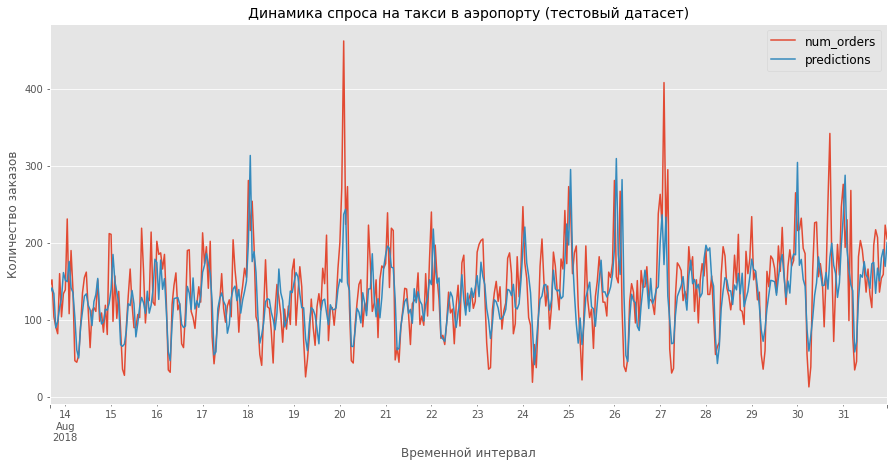

In [113]:
plt.figure(figsize=(15,7))

# тестовая выборка
(test_bl
     # берем столбец с целевым признаком
     .num_orders.to_frame()
    
      # добавляем столбец с предсказаниями
     .assign(predictions = model_cbr.predict(cat_features_test_bl))     
     .plot(ax=plt.gca())
);
plt.title("Динамика спроса на такси в аэропорту (тестовый датасет)", fontsize=14)
plt.legend(fontsize=12)
plt.xlabel("Временной интервал", size=12)
plt.ylabel("Количество заказов", size=12)
plt.show()

Модель отлично поймала спады спроса, а вот с положительными пиками справилась плохо.

Проверим, в какие моменты модель была более точной и менее точной. Для наглядности графика построим последние 10 дней

In [224]:
preds_test = pd.Series(model_cbr.predict(cat_features_test_bl), index = target_test_bl.index, name='preds')
df_preds = pd.concat([target_test_bl, preds_test], axis=1)
df_preds.head(10)

,num_orders,preds
datetime,,
2018-08-13 16:00:00,144,144.943153
2018-08-13 17:00:00,152,134.643876
2018-08-13 18:00:00,104,109.826088
2018-08-13 19:00:00,91,95.296882
2018-08-13 20:00:00,82,100.975111
2018-08-13 21:00:00,160,121.861978
2018-08-13 22:00:00,104,129.159703
2018-08-13 23:00:00,134,152.347146
2018-08-14 00:00:00,139,157.604485


По графику  и таблице видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные  в самом начале. Однако резкие пики в данных предсказать не может. Возможно, для этого необходимо ввести признак 'выходной день' и отработать важность признаков для модели.

# Вывод


Успешно построена модель для предсказания спроса на такси в ближайший час.

Лучшие результаты на  показала модель  CatBoostRegressor
RMSE = 27.468 - обучающий датасет
RMSE = 45.44 - тестовая выборка

Для достижения цели исльзовались разные подходы:

- рассмотрены несколько моделей машинного обучения: Linear, Ridge, RandomForest, LGBMRegressor,CatBoost, ARIMA
- статистические графики с автокорреляцией PACF и ACF
- сравнивание параметров с помощью линейной модели
- генерация и подбир признаков  для SupervisedLearning:
  - Лаги
  - "Скользящие" статистики".

Поставленный KPI с RMS <= 48 достигнут!

Также познакомились с возможностями ARIMA, которая в текущем проекте показала высокую скорость.

По результатам видно, что модель достаточно сильно переобучается. Резкие пики в данных в конце августа предсказать не может. Возможно, для этого необходимо ввести признак 'выходной день', отработать важность признаков для модели,сфокусировавшись на росте спроса, построить модель предсказаний для стационарного ряда (после дифференцирования).